In [1]:
### Import libraries

%matplotlib inline
import xarray as xr
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

import cartopy
import cartopy.crs as ccrs

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [2]:
### Base path to files
base_path = '/nethome/5867800/'

# General settings and preparation

In [3]:
### Define functions for preparation of data and plotting

def prepare_outline_modern_plot(ax):
    '''
    Prepare map (boundaries, coastlines, gridlines) for plotting modern iceberg trajectories.
    
    Parameters:
    ---
    ax : matplotlib axes object
        
    Returns:
    ---
    ax : modified matplotlib axes object with extent, boundary, coastlines, and gridlines.
    '''
    
    # Set extent and boundary
    ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())
    
    ylim = [-90,-60]
    xlim = [-90, 90]
    rect = mpath.Path([[xlim[0], ylim[0]],
                       [xlim[1], ylim[0]],
                       [xlim[1], ylim[1]],
                       [xlim[0], ylim[1]],
                       [xlim[0], ylim[0]],
                       ]).interpolated(40)
    proj_to_data   = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    
    # Coastline
    ax.coastlines(zorder=2)
    
    # Gridlines
    gl_configurations = [([-60, -30, 0, 30, 60], []),   # -60, -30, 0, 30, 60 W/E
                         ([], np.arange(-90,-69,10)),   # 90, 80, 70 S ###, 60 S
                         ([], np.arange(-60,-59,10))]   # 60 S ### 50 S
    
    for i in range(len(gl_configurations)):
        gl = ax.gridlines(linestyle='--' if i < 2 else '-', linewidth=.7 if i < 2 else 1,
                          draw_labels=True, x_inline=False, y_inline=False,
                          crs=ccrs.PlateCarree(), zorder=5)
        
        gl.xlocator = mticker.FixedLocator(gl_configurations[i][0])
        gl.ylocator = mticker.FixedLocator(gl_configurations[i][1])
        
        # Position labels
        if i == 0:     # along sides and top
            gl.right_labels  = True
            gl.bottom_labels = False
            gl.left_labels   = True
            gl.top_labels    = True
        elif i == 1:   # along bottom
            gl.right_labels  = False
            gl.bottom_labels = True
            gl.left_labels   = False
            gl.top_labels    = False
        else:   # lines
            gl.right_labels  = False
            gl.bottom_labels = False
            gl.left_labels   = False
            gl.top_labels    = False
        
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}
        
        # Remove double coordinate labels
        if i == 0:
            gl_adapt1 = gl
        if i == 1:
            gl_adapt2 = gl

    return ax, gl_adapt1, gl_adapt2

In [4]:
### Locations

# ODP Site 696
x696_pd, y696_pd = -42.933067, -61.849083   # present-day coordinates [°]

# Forwards release locations [°]
lons_fw = np.array([-55., -50., -45., -40., -35.,
                    -30., -25., -20., -15., -10.,
                     -5.,   0.,   5.,  10.,  15.,
                     20.,  25.,  30.,  35.,  40.,
                     45.,  50.,  55.,  60., -57.82330253])
lats_fw = np.array([-77.99537227, -78.45787684, -79.17977465, -79.75459498, -79.99027112,
                    -80.07689735, -79.9997914 , -80.12097168, -79.24559138, -78.39033646,
                    -77.33178711, -76.13251966, -75.17986379, -74.68456009, -73.6896764 ,
                    -73.53134648, -72.9724492 , -72.3117251 , -72.29006817, -72.16268516,
                    -70.86573029, -68.58359528, -68.58359528, -66.59729004, -77.])

# Modern simulations

Short forward simulations with present-day flow fields are performed to analyse the difference in results between using daily/hourly and monthly values.

In [5]:
### Load data
day = xr.open_zarr(base_path + 'modern/modern_1y_int_30d_1hdtar_C4_hourly.zarr')        # daily/hourly
mon = xr.open_zarr(base_path + 'modern/modern_1y_int_30d_1hdtar_C4_monthly_ate.zarr')   # monthly

Mask non-positive values (automatic initial values are set to zero in the model) and group per month to analyse wave erosion through time.

In [6]:
### Mask zero values
day_masked = day.where(day['M'] > 0.)
mon_masked = mon.where(mon['M'] > 0.)

### Group per month
dmn = day_masked.groupby('time.month').mean()
mmn = mon_masked.groupby('time.month').mean()

Plot the trajectories of the modern icebergs using hourly/daily fields or monthly fields to compare the difference in trajectories.

Trajectories plotted...
Saving figure...


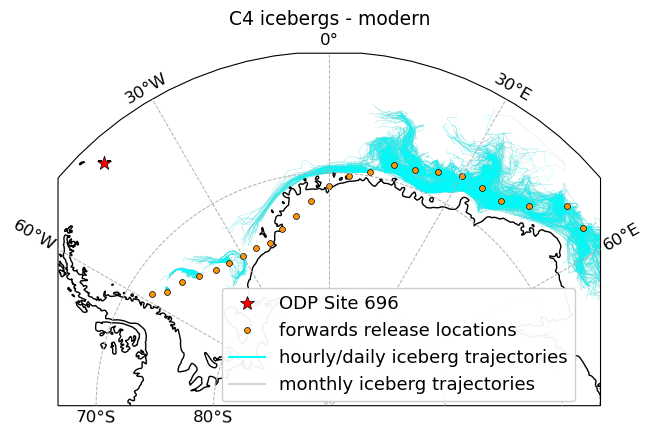

In [7]:
### Plot trajectories

# Prepare axes
fig, ax = plt.subplots(nrows=1,ncols=1, subplot_kw={'projection': ccrs.SouthPolarStereo()}, figsize=(7,4.6))
ax, gl1, gl2 = prepare_outline_modern_plot(ax)
ax.set_title('C4 icebergs - modern', fontsize=13.5)

# Plot trajectories
ax.plot(day['lon'].values.T, day['lat'].values.T, transform=ccrs.PlateCarree(), linewidth=.1, zorder=1, color='cyan', rasterized=True)
ax.plot(mon['lon'].values.T, mon['lat'].values.T, transform=ccrs.PlateCarree(), linewidth=.1, zorder=0, color='darkgrey', rasterized=True)
print(f'Trajectories plotted...')

# Plot ODP
ax.scatter(x696_pd, y696_pd, transform=ccrs.PlateCarree(), color='r', marker='*', s=110, edgecolor='black', linewidth=.5, zorder=3)

# Plot release locations
ax.scatter(lons_fw, lats_fw+5., transform=ccrs.PlateCarree(), color='xkcd:tangerine', s=18, edgecolor='k', linewidths=.5, zorder=3)

# Legend
handles, labels = ax.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(110),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(18),
             markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
handles.append(rel)
suc = Line2D([0], [0], label='hourly/daily iceberg trajectories', color='cyan')
handles.append(suc)
oth = Line2D([0], [0], label='monthly iceberg trajectories', color='lightgrey')
handles.append(oth)
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.97, .36), fontsize='13', framealpha=0.95)

plt.draw()

# Fix coordinate labels
for j, ea in enumerate(gl1.label_artists):
    if j == 5:
        ea[2].set_color('white')
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

for j, ea in enumerate(gl2.label_artists):
    if '-' not in str(ea[2]):
        ea[2].set_color('white')
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

print(f'Saving figure...')
plt.savefig(f'figures/Paper/FS06aModernTrajectories.pdf', bbox_inches='tight', dpi=300)
plt.show()

Plot temporal evolution of wave erosion to study the difference in magnitude between using hourly/daily or monthly values.

Trajectories plotted...
Saving figure...


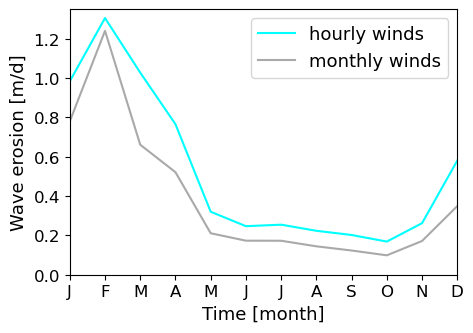

In [8]:
### Plot temporal evolution wave erosion

# Prepare axes
fig, ax = plt.subplots(figsize=(5, 3.45))

ax.plot(dmn['month'].values, dmn['Mer'].values*86400., label= 'hourly winds', c='cyan')
ax.plot(mmn['month'].values, mmn['Mer'].values*86400., label='monthly winds', c='darkgrey')
print(f'Trajectories plotted...')

# Set axes properties and legend
ax.set_xlim(1, 12)
ax.set_xlabel('Time [month]', fontsize=13)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=12)
ax.set_ylim(0, 1.35)
ax.set_ylabel('Wave erosion [m/d]', fontsize=13)
ax.tick_params(axis='y', which='both', labelsize=12)
ax.legend(fontsize=13)

print(f'Saving figure...')
plt.savefig(f'figures/Paper/FS06bModernWaveErosion.pdf', bbox_inches='tight', dpi=300)
plt.show()